# Project description

In this project, our task is to build a model to determine the cost of a car for a used car sales service, which is developing an app to attract new customers.   
We have historical data at our disposal: technical specifications, configurations, and prices of cars.  

The customer is concerned about:  

- quality of prediction;
- speed of prediction;
- training time.  

To evaluate the quality of the models, we will use the RMSE metric.

## Date features

- DateCrawled — date of downloading the questionnaire from the database
- VehicleType — type of car body
- RegistrationYear — year of car registration
- Gearbox — type of transmission
- Power — power (hp)
- Model — car model
- Kilometer — mileage (km)
- RegistrationMonth — month of car registration
- FuelType — type of fuel
- Brand — car brand
- NotRepaired — whether the car was in repair or not
- DateCreated — date of creation of the questionnaire
- NumberOfPictures — number of car photos
- PostalCode — postal code of the questionnaire owner (user)
- LastSeen — date of the last user activity  

Target feature  

- Price — price (Euro)

# Work plan for the project

To perform the task, we will carry out the following steps:
- Load and prepare the data;
- Train models with different hyperparameters;
- Analyze the speed of operation and quality of models.  

Notes:
- To evaluate the quality of the models, we will use the RMSE metric.

# 1. Data preparation

In [58]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

pd.set_option('display.max_columns', 100)

***
### Preliminary study of data

We will load the data and take a look at it.

In [2]:
cars = pd.read_csv('/datasets/autos.csv')

In [3]:
cars.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


***
**Conclusion**

The dataset contains about 355,000 objects and 16 features, the target of which is the Price feature.  
Training features are in int or object format, including 2 date features.  

**Features**  

- DateCrawled — date of downloading the questionnaire from the database
- VehicleType — type of car body
- RegistrationYear — year of car registration
- Gearbox — type of transmission
- Power — power (hp)
- Model — car model
- Kilometer — mileage (km)
- RegistrationMonth — month of car registration
- FuelType — type of fuel
- Brand — car brand
- NotRepaired — whether the car was in repair or not
- DateCreated — date of creation of the questionnaire
- NumberOfPictures — number of car photos
- PostalCode — postal code of the questionnaire owner (user)
- LastSeen — date of the last user activity  

**Target feature**

- Price — price (Euro)

***
## Preprocessing of data

Let's convert column names to lowercase

In [5]:
new_names = cars.columns.str.lower()
cars.set_axis(new_names, axis = 'columns', inplace = True)
cars.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

Let's find and remove duplicates.

In [6]:
print('Number of duplicates before deleting:', cars.duplicated().sum())
cars = cars.drop_duplicates().reset_index(drop = True)
print('Number of duplicates after deleting:', cars.duplicated().sum())

Количество дубликатов до удаления: 4
Количество дубликатов после удаления: 0


### Missing value processing

In [7]:
def miss_inf(data):
    shape_data = data.shape
    miss_data = (data.isnull().sum()/data.shape[0]*100).sort_values(ascending = False).head(10)
    print('Number of rows, columns:', shape_data)
    print()
    print('Share of missing values in columns (top-10):')
    print(miss_data)

In [8]:
miss_inf(cars)

Количество строк, столбцов: (354365, 16)

Доля пропущенных значений в столбцах (топ-10):
notrepaired         20.079297
vehicletype         10.579487
fueltype             9.282802
gearbox              5.596772
model                5.560651
lastseen             0.000000
postalcode           0.000000
numberofpictures     0.000000
datecreated          0.000000
brand                0.000000
dtype: float64


There are gaps in 5 features:  

- notrepaired - whether the car was in repair or not. About 20% of missing values.  
In this case, missing values may mean that the car was not in repair. We will fill them with the 'no' value;
- vehicletype - type of car body. A little over 10% of missing values.  
In this case, we will fill in the gaps with the most frequent values grouped by brand and model;
- fueltype - type of fuel. About 10% of missing values.  
We will fill in the gaps similarly to the body type - the most frequent values grouped by brand and model;
-  gearbox - type of transmission. About 5% of missing values.  
We will fill in the gaps similarly to the body type - the most frequent values grouped by brand and model;
- model - car model. About 5% of missing values.  

We will fill in the gaps with the most frequent values grouped by brand and release year.

Let's fill in the gaps in the notrepaired feature

In [9]:
cars['notrepaired'] = cars['notrepaired'].fillna('no')

Let's fill in the gaps in the model feature, after that we will fill in the gaps in the fueltype, vehicletype, gearbox features.

In [10]:
def filler(data, column1, column2, column):
    cars[column] = cars.groupby([column1, column2])[column].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "Empty")))

In [11]:
filler(cars, 'brand', 'registrationyear', 'model')
filler(cars, 'brand', 'model', 'fueltype')
filler(cars, 'brand', 'model', 'vehicletype')
filler(cars, 'brand', 'model', 'gearbox')

Let's check for missing values.

In [12]:
cars.isnull().sum()

datecrawled          0
price                0
vehicletype          0
registrationyear     0
gearbox              0
power                0
model                0
kilometer            0
registrationmonth    0
fueltype             0
brand                0
notrepaired          0
datecreated          0
numberofpictures     0
postalcode           0
lastseen             0
dtype: int64

Let's check how many objects we got with the value of the model feature = Empty.

In [13]:
cars['model'][cars['model'] == 'Empty'].count()/cars.shape[0]

0.009713148871925838

Since there are less than 1% of such objects, we will remove them from the sample.

In [14]:
cars = cars[cars['model'] != 'Empty'].reset_index(drop = True)

### The study of the values of quantitative features

There are 4 features in the table indicating the date of the event:

- datecrawled — date of downloading the questionnaire from the database;
- registrationyear — year of the car registration;
- registrationmonth — month of the car registration;
- datecreated — date of the questionnaire creation;
- lastseen - date of the last user activity.  

We will remove 4 of them, leaving only the registrationyear feature.   
Also, we will immediately remove the postalcode feature — the owner's postal code (user).

In [15]:
cars = cars.drop(['datecrawled', 'registrationmonth', 'datecreated', 'lastseen', 'postalcode'], axis=1)

Let's study the distribution of values in the remaining quantitative features:

- registrationyear — year of the car registration;
- power — power (hp);
- kilometer — mileage (km);
- numberofpictures — number of car photos

**The study of the values of the registrationyear column**

In [16]:
cars['registrationyear'].describe()

count    350923.000000
mean       2003.938328
std          71.953394
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registrationyear, dtype: float64

We see that there are abnormal values of the car's release year. We will remove all values below 1950 and above 2020.

In [17]:
cars = cars.query('1950 <= registrationyear <= 2020')

**The study of the distribution of the target feature of the sample - the price column**

In [18]:
def graph(data, column, title):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    axes[0].set_title(title)
    sns.boxplot(y = column, data=data, palette='rainbow', ax = axes[0])
    axes[0].set_xlabel('Quantity')
     
    axes[1].set_title(title)
    sns.distplot(data[column], kde=False, bins=50, ax = axes[1])
    axes[1].set_ylabel('Quantity')
            
    plt.show()
    
    print(data[column].describe())

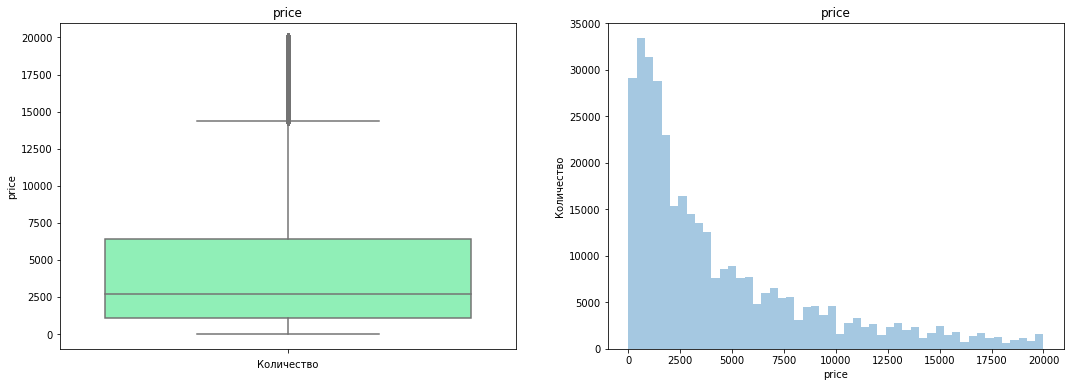

count    350716.000000
mean       4411.664398
std        4502.620498
min           0.000000
25%        1099.000000
50%        2700.000000
75%        6399.000000
max       20000.000000
Name: price, dtype: float64


In [19]:
graph(cars, 'price', 'price')

From the graphs, we can see that a very large number of values are close to zero and this shifts the boxplot graph, making it notnformative.    
We will temporarily remove objects with a price equal to 0 and look at the distribution. 

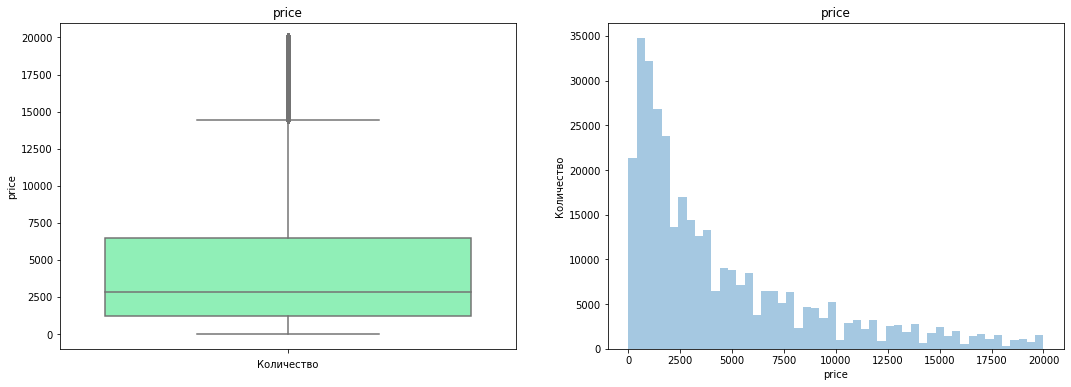

count    340524.000000
mean       4543.707025
std        4503.379163
min           1.000000
25%        1200.000000
50%        2850.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64


In [20]:
cars_price_not_null = cars.query('price != 0')
graph(cars_price_not_null, 'price', 'price')

The situation did not clear up much, but we see that there are about 10 thousand zero values.  
In this case, we will find the 1-5% quantiles of the distribution.

In [21]:
print('Price value at the quantile 0.01 - ', cars['price'].quantile(0.01))
print('Price value at the quantile 0.02 - ', cars['price'].quantile(0.02))
print('Price value at the quantile 0.03 - ', cars['price'].quantile(0.03))
print('Price value at the quantile 0.04 - ', cars['price'].quantile(0.04))
print('Price value at the quantile 0.05 - ', cars['price'].quantile(0.05))

Значение цены при квантиле 0.01 -  0.0
Значение цены при квантиле 0.02 -  0.0
Значение цены при квантиле 0.03 -  1.0
Значение цены при квантиле 0.04 -  130.0
Значение цены при квантиле 0.05 -  200.0


Information about the quantiles gave us a better understanding of the minimum car prices - in 3% of ads, the car price is lower or equal to 1 dollar. These are clear outliers.  
We can choose a starting price of 200 dollars for a car and remove objects with a lower price.

In [22]:
cars = cars.query('price >= 200')

**The study of the distribution of the sample feature - the power column**

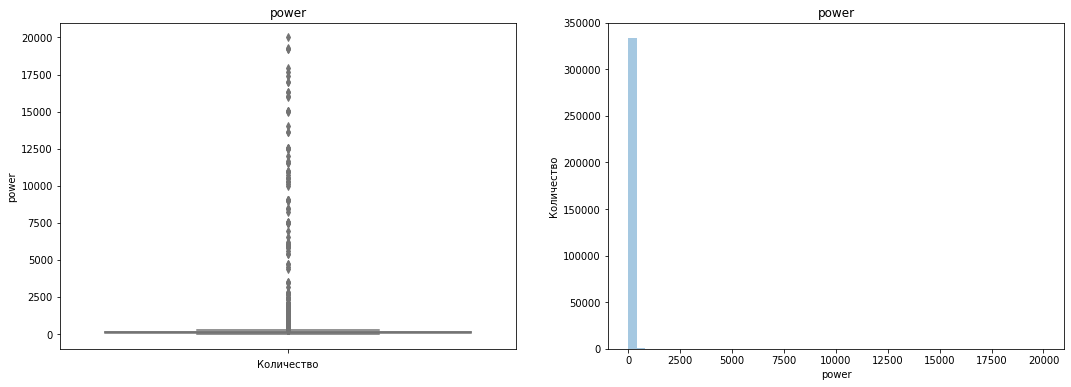

count    334075.000000
mean        112.139388
std         187.183172
min           0.000000
25%          72.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64


In [23]:
graph(cars, 'power', 'power')

The graph shows that there are many outliers, and due to them, the graphs are almost unreadable.  
Let's build graphs with a limitation of values on the X-axis - the right border will be the Q3 + 4 x IQR value, the left one Q1 - IQR.

In [24]:
def graph_hist(data, column, bins, xlabel, ylabel):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    fig, ax = plt.subplots()
    column.plot(kind = 'hist', bins = bins, grid = True,
                       range = (Q1 - IQR, Q3 + 3*IQR), figsize = (7, 4)
                      )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

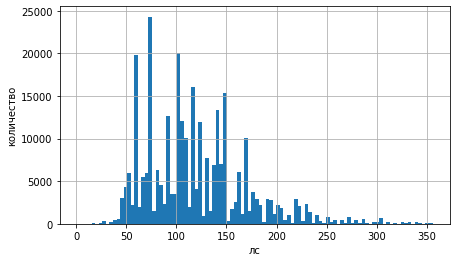

In [25]:
graph_hist(cars, cars['power'], 100, 'лс', 'количество')

The graph has become more readable, and it shows:  

- there is a very large number of objects with a power equal to zero;
- objects with power greater than 350 hp are almost not found.  

Based on this, we will remove power values above 350 hp and replace zero values with median ones, grouped by car model.

In [26]:
cars = cars.query('power <= 350')

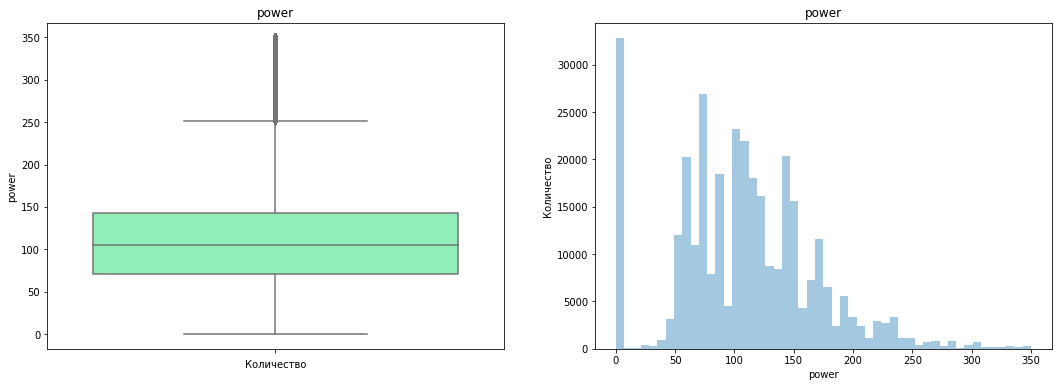

count    332993.000000
mean        108.014751
std          60.350272
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max         350.000000
Name: power, dtype: float64


In [27]:
graph(cars, 'power', 'power')

In [28]:
medians  = cars.groupby('model')['power'].median(skipna = True).to_dict()
def filler (row):
    if row['power'] == 0:
        return medians [row['model']]
    return row ['power']
cars['power'] = cars.apply(lambda row: filler(row), axis = 1)

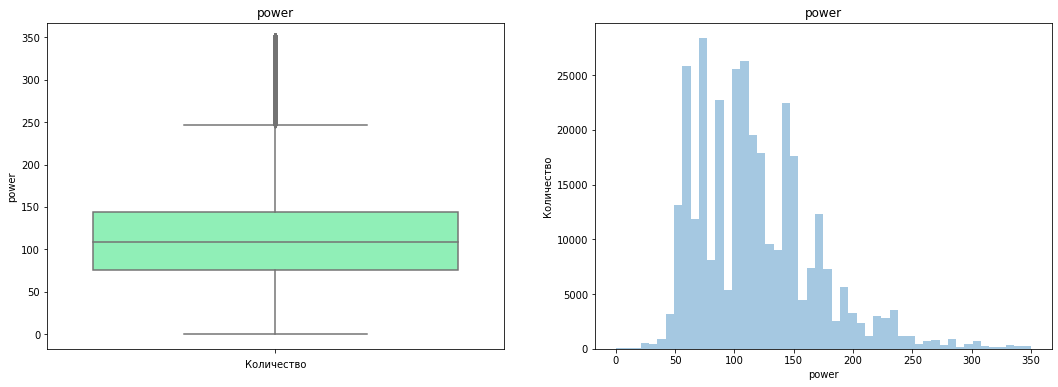

count    332993.000000
mean        118.251555
std          50.328187
min           0.000000
25%          75.000000
50%         109.000000
75%         144.000000
max         350.000000
Name: power, dtype: float64


In [29]:
graph(cars, 'power', 'power')

The values of the quantiles have not changed much, got rid of zeros. Great!

**The study of the distribution of the sample feature - the kilometer column**

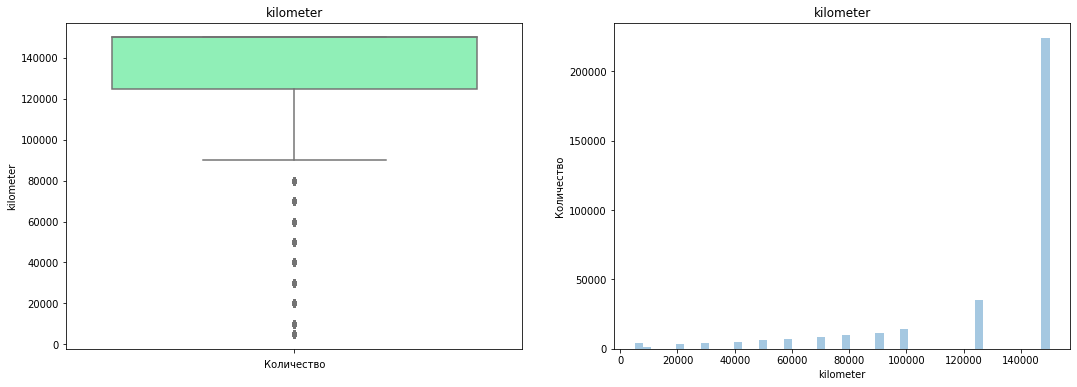

count    332993.000000
mean     128785.424919
std       36789.596306
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64


In [30]:
graph(cars, 'kilometer', 'kilometer')

The kilometer feature data are distributed discretely, and the median is simultaneously the maximum value.  
We will count the exact number of each value in the distribution. We will not change anything.

In [31]:
cars['kilometer'].value_counts()

150000    223970
125000     35035
100000     13955
90000      11172
80000       9711
70000       8295
60000       7228
50000       6009
40000       4752
30000       4159
5000        4144
20000       3593
10000        970
Name: kilometer, dtype: int64

We can see that the largest number of cars have a mileage of 150,000 km - perhaps this is the maximum value that can be entered in the application.

**The study of the distribution of the sample feature - the numberofpictures column**

Very often, the number of car photos affects the speed of sales, so this parameter can be important.  
Let's look at its distribution.

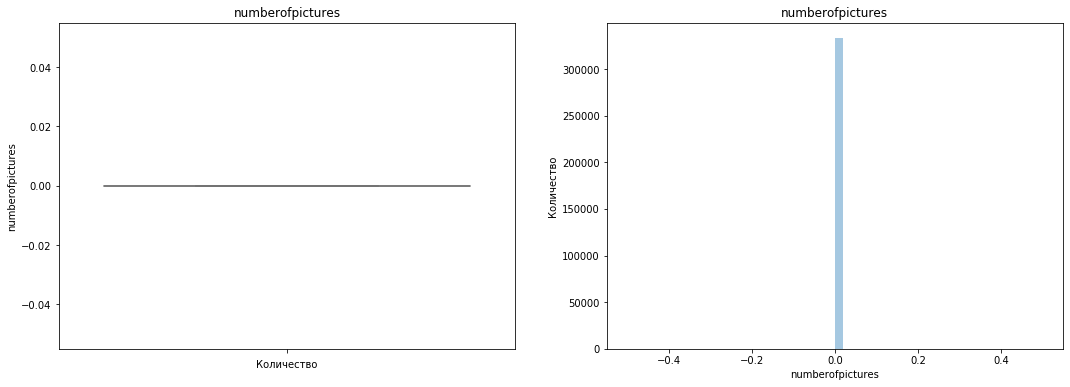

count    332993.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: numberofpictures, dtype: float64


In [32]:
graph(cars, 'numberofpictures', 'numberofpictures')

All values are equal to zero. We will remove this column and look at the final table.

In [33]:
cars = cars.drop(['numberofpictures'], axis=1)
cars

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
0,480,sedan,1993,manual,90.0,golf,150000,petrol,volkswagen,no
1,18300,coupe,2011,manual,190.0,a4,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
350917,3200,sedan,2004,manual,225.0,leon,150000,petrol,seat,yes
350918,1150,bus,2000,manual,120.0,zafira,150000,petrol,opel,no
350920,1199,convertible,2000,auto,101.0,fortwo,125000,petrol,smart,no
350921,9200,bus,1996,manual,102.0,transporter,150000,gasoline,volkswagen,no


***
## Conclusion

At this stage, data preprocessing has been carried out for further analysis:

- Duplicates have been removed;
- Missing values have been filled in;
- Data outliers in quantitative features have been removed;
- Features that will not be needed in further model training have been removed.

# 2. Model Training

At this stage, we will prepare data for training various forecasting models, train the models, and select the best one.

***
## Data Preparation for Training

We will prepare the data for training by performing the following actions:

- split the sample into training and target;
- convert the type of categorical features from object to categorial;
- perform scaling of quantitative features.

***
### Splitting the Sample into Training and Target

Let's separate the target feature price into a separate table

In [34]:
cars_features = cars.drop(['price'], axis=1)
cars_target = cars['price']

***
### Conversion of Categorical Features

For training our models, we will need to change the type of categorical features from object to category.

In [35]:
categorial = {'vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired'}

for cat in categorial:
    cars_features[cat] = cars_features[cat].astype('category')

In [36]:
cars_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 332993 entries, 0 to 350922
Data columns (total 9 columns):
vehicletype         332993 non-null category
registrationyear    332993 non-null int64
gearbox             332993 non-null category
power               332993 non-null float64
model               332993 non-null category
kilometer           332993 non-null int64
fueltype            332993 non-null category
brand               332993 non-null category
notrepaired         332993 non-null category
dtypes: category(6), float64(1), int64(2)
memory usage: 12.4 MB


***
### Scaling Quantitative Features

Now we will perform scaling of the data in the remaining numerical columns.  
Before scaling, we will divide the data into 3 samples - training, validation, and testing in a ratio of 60/20/20.

In [37]:
cars_ftrain, cars_frest, cars_ttrain, cars_trest = train_test_split(
    cars_features, cars_target, test_size=0.25, random_state=12345)
cars_fvalid, cars_ftest, cars_tvalid, cars_ttest = train_test_split(
    cars_frest, cars_trest, test_size=0.5, random_state=12345)

In [38]:
print(cars_ftrain.shape)
print(cars_fvalid.shape)
print(cars_ftest.shape)

(249744, 9)
(41624, 9)
(41625, 9)


Now we will perform scaling of quantitative features using the Standardization method.  
Standardization implies such data preprocessing after which each feature has an average of 0 and a variance of 1.  
We will first check the distribution of feature values and create a standardization function.

In [39]:
cars_ftrain.describe().round(4)

,registrationyear,power,kilometer
count,249744.0000,249744.0000,249744.0000
mean,2003.3432,118.2716,128810.8823
std,7.0383,50.3434,36767.1106
min,1950.0000,0.0000,5000.0000
25%,1999.0000,75.0000,125000.0000
50%,2003.0000,109.0000,150000.0000
75%,2008.0000,144.0000,150000.0000
max,2019.0000,350.0000,150000.0000


In [40]:
def scalers(train, valid, test):
    numeric = ['registrationyear', 'power', 'kilometer']
    scaler = StandardScaler()
    scaler.fit(train[numeric])
    train[numeric] = scaler.transform(train[numeric])
    valid[numeric] = scaler.transform(valid[numeric])
    test[numeric] = scaler.transform(test[numeric])

In [41]:
scalers(cars_ftrain, cars_fvalid, cars_ftest)

Now we will perform scaling of quantitative features using the Standardization method.

In [42]:
cars_ftrain.describe().round(4)

,registrationyear,power,kilometer
count,249744.0000,249744.0000,249744.0000
mean,-0.0000,0.0000,-0.0000
std,1.0000,1.0000,1.0000
min,-7.5790,-2.3493,-3.3674
25%,-0.6171,-0.8595,-0.1036
50%,-0.0488,-0.1842,0.5763
75%,0.6616,0.5111,0.5763
max,2.2245,4.6030,0.5763


Standardization implies such data preprocessing after which each feature has an average of 0 and a variance of 1.  
We will first check the distribution of feature values and create a standardization function.

***
### Conclusion

The data has been prepared for model training:
- Splitting the sample into training and target;
- Conversion of categorical features from object to categorial;
- Scaling of quantitative features.

***
## Gradient Boosting Model Training

We will conduct training of gradient boosting models from two libraries and compare the results:

- LightGBM - LGBMRegressor;
- CatBoost - CatBoostRegressor.  

We choose these two models because of their fast operation and ability to work with categorical features without the need to convert them to numbers.

Let's create a list with the names of the categorical columns.

In [43]:
cat_columns = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']

**LGBMRegressor**

Let's create a function that takes as arguments the features and the target feature, and on output gives a dictionary with the best hyperparameters and the best result for the LGBMRegressor model.

In [44]:
def lgb_gridsearchcv(features, target):
    model = LGBMRegressor()
    param_grid = {
        'boosting_type' : ['gbdt'],
        'n_estimators' : [50, 100],
        'max_depth' : [5, 7, 10],
        'verbose' : [0],
        'random_state' : [12345]        
    }
    CV = GridSearchCV(estimator = model, param_grid = param_grid, cv = 2, scoring = 'neg_mean_squared_error')
    CV.fit(features, target, categorical_feature = cat_columns)
    print('The best hyperparametres: ', CV.best_params_)
    print('The best RMSE: {:.2f}'.format((-CV.best_score_) ** 0.5))

Let's apply it to the existing sample.

In [45]:
%%time
lgb_gridsearchcv(cars_ftrain, cars_ttrain)

Лучшие гиперпараметры:  {'boosting_type': 'gbdt', 'max_depth': 10, 'n_estimators': 100, 'random_state': 12345, 'verbose': 0}
Лучшее RMSE: 1675.80
CPU times: user 1min 14s, sys: 376 ms, total: 1min 14s
Wall time: 1min 15s


Let's check the best hyperparameters on the validation sample.

In [46]:
%%time

LGBMR = LGBMRegressor(random_state = 12345, max_depth = 10, n_estimators = 100, verbose = 0)
LGBMR.fit(cars_ftrain, cars_ttrain, categorical_feature = cat_columns)
prediction = LGBMR.predict(cars_fvalid)
rmse = mean_squared_error(prediction, cars_tvalid) ** 0.5
print(f'RMSE_test {rmse:.2f}')

RMSE_test 1654.23
CPU times: user 9.58 s, sys: 48.2 ms, total: 9.63 s
Wall time: 9.7 s


**Conclusion**

From this relatively small list of parameters, the best ones were 'boosting_type' : 'gbdt', 'max_depth': 10, 'n_estimators': 100.  
- Best RMSE: 1654.23
- Wall time: 9.7 s  
  
The function worked quite quickly, but with a larger number of parameters and when using other search algorithms, the speed significantly deteriorated, and the gridsearch function took several tens of minutes to find the solution.

**CatBoostRegressor**

Let's create a function that takes as arguments the features and the target feature, and on output gives a dictionary with the best hyperparameters and the best result for the CatBoostRegressor model.

In [47]:
def cat_gridsearchcv(features, target):
    model = CatBoostRegressor()
    param_grid = {
        'n_estimators' : [50, 100],
        'max_depth' : [5, 7, 10],
        'verbose' : [0],
        'random_state' : [12345]        
    }
    CV = GridSearchCV(estimator = model, param_grid = param_grid, cv = 2, scoring = 'neg_mean_squared_error')
    CV.fit(features, target, cat_features = cat_columns)
    print('Лучшие гиперпараметры: ', CV.best_params_)
    print('Лучшее RMSE: {:.2f}'.format((-CV.best_score_) ** 0.5))

Let's apply it to the existing sample.

In [48]:
%%time
cat_gridsearchcv(cars_ftrain, cars_ttrain)

Лучшие гиперпараметры:  {'max_depth': 10, 'n_estimators': 100, 'random_state': 12345, 'verbose': 0}
Лучшее RMSE: 1888.62
CPU times: user 3min 41s, sys: 22.7 s, total: 4min 3s
Wall time: 4min 45s


Let's check the best hyperparameters on the validation sample.

In [49]:
%%time

CBR = CatBoostRegressor(random_state = 12345, max_depth = 10, n_estimators = 100, verbose = 0)
CBR.fit(cars_ftrain, cars_ttrain, cat_features = cat_columns)
prediction = CBR.predict(cars_fvalid)
rmse = mean_squared_error(prediction, cars_tvalid) ** 0.5
print(f'RMSE_test {rmse:.2f}')

RMSE_test 1866.72
CPU times: user 42.4 s, sys: 2.95 s, total: 45.4 s
Wall time: 48.7 s


**Conclusion**

In this model, the best parameters were also 'max_depth': 10, 'n_estimators': 100.
- Best RMSE: 1866.72
- Wall time: 48.7 s  
  
However, the best RMSE indicator and the speed of learning were significantly worse than for the LGBMRegressor

***
### Conclusion

At this stage, data preparation for model operation was carried out, and LGBMRegressor and CatBoostRegressor models were built.
The best RMSE result and the best speed were shown by the LGBMRegressor model.  
  
Best hyperparameters: 'boosting_type' : 'gbdt', 'max_depth': 10, 'n_estimators': 100, 'random_state': 12345, 'verbose': 0
The best RMSE result is 1650.82. Training and prediction time is 17.3 seconds.  
  
When selecting other hyperparameters, such as learning_rate, num_leaves, min_data_in_leaf, the result remained roughly the same, but the speed of work significantly decreased.

## Training of prediction models requiring dummy transformation - linear regression, random forest, GradientBoostingRegressor.

Copy the dataset

In [51]:
cars_2 = cars.copy()

Conduct one-hot encoding of categorical features and split the data into samples.

In [55]:
cars_ohe = pd.get_dummies(cars_2, drop_first=True)

cars_ohe_features = cars_ohe.drop(['price'], axis=1)
cars_ohe_target = cars_ohe['price']

features_train, features_rest, target_train, target_rest = train_test_split(cars_ohe_features, cars_ohe_target,
                                                                              test_size = 0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_rest, target_rest, test_size=0.5,
                                                                                random_state=12345)
print("The size of the training sample", features_train.shape)
print("The size of the validating sample", features_valid.shape)
print("The size of the test sample", features_test.shape)

Размер обучающей выборки (199795, 305)
Размер валидационной выборки (66599, 305)
Размер тестовой выборки (66599, 305)


Scale the quantitative features.

In [57]:
scalers(features_train, features_valid, features_test)

Train the forecasting models:

Linear Regression

In [62]:
%%time

LNR = LinearRegression(n_jobs=-1)
LNR.fit(features_train, target_train)
prediction = LNR.predict(features_valid)
rmse = mean_squared_error(prediction, target_valid) ** 0.5
print(f'RMSE_test {rmse:.2f}')

RMSE_test 2695.28
CPU times: user 16.7 s, sys: 4.58 s, total: 21.2 s
Wall time: 21.5 s


Random Forest

In [64]:
%%time

RFR = RandomForestRegressor(n_estimators=100, max_depth=10, max_features=10, random_state=12345)
RFR.fit(features_train, target_train)
prediction = RFR.predict(features_valid)
rmse = mean_squared_error(prediction, target_valid) ** 0.5
print(f'RMSE_test {rmse:.2f}')

RMSE_test 2447.50
CPU times: user 39.2 s, sys: 180 ms, total: 39.4 s
Wall time: 39.6 s


GradientBoostingRegressor

In [66]:
%%time

GBR = GradientBoostingRegressor()
GBR.fit(features_train, target_train)
prediction = GBR.predict(features_valid)
rmse = mean_squared_error(prediction, target_valid) ** 0.5
print(f'RMSE_test {rmse:.2f}')

RMSE_test 1928.88
CPU times: user 2min 38s, sys: 0 ns, total: 2min 38s
Wall time: 2min 42s


The GradientBoostingRegressor model showed the best result in terms of the RMSE metric, but its result is still much worse than the LGBMRegressor model

**Testing the LGBMRegressor model on test data**

In [50]:
%%time

LGBMR = LGBMRegressor(random_state = 12345, max_depth = 10, n_estimators = 100, verbose = 0)
LGBMR.fit(cars_ftrain, cars_ttrain, categorical_feature = cat_columns)
prediction = LGBMR.predict(cars_ftest)
rmse = mean_squared_error(prediction, cars_ttest) ** 0.5
print(f'RMSE_test {rmse:.2f}')

RMSE_test 1640.17
CPU times: user 9.18 s, sys: 0 ns, total: 9.18 s
Wall time: 9.3 s


Testing the LGBMRegressor model on test data.

# 3. Analysis of models

In this project, due to the need to analyze and train a model on a large sample (over 300 thousand objects), it was decided to train gradient boosting models.  
The most common gradient boosting libraries are:

- XGBoost (from extreme gradient boosting) - a popular gradient boosting library on the Kaggle platform. Open source software. Released in 2014.
- LightGBM (from light gradient boosting machine). Developed by Microsoft, it quickly and accurately trains gradient boosting. Works directly with categorical features.
- CatBoost (from categorical boosting). Developed by Yandex, it surpasses other algorithms in terms of quality metrics. Applies various techniques of encoding categorical features (LabelEncoding, One-Hot Encoding).  

We chose the LightGBM and CatBoost libraries from them and trained the LGBMRegressor and CatBoostRegressor models.  
Despite the declared learning speed, the hyperparameter tuning took a very long time, and in the end, it was decided to stop at the choice of two hyperparameters - max_depth, n_estimators.  
  
In both models, the best values were 'max_depth': 10, 'n_estimators': 100, however, the LGBMRegressor model showed a better RMSE result and faster training and prediction time.

In [81]:
d = {'Model' : ['LightGBM', 'CatBoost', 'LinearRegression', 
                                         'RandomForestRegressor', 'GradientBoostingRegressor'],
    'RMSE' :pd.Series([1654.23, 1866.72, 2695.28, 2447.50, 1928.88]),
     'time, s': pd.Series([10, 49, 22, 40, 162])
    }
df1 = pd.DataFrame(d)
df1

,Model,RMSE,"time, s"
0,LightGBM,1654.23,10
1,CatBoost,1866.72,49
2,LinearRegression,2695.28,22
3,RandomForestRegressor,2447.50,40
4,GradientBoostingRegressor,1928.88,162
